<a href="https://colab.research.google.com/github/wangyuyyt/self_driving_car_server/blob/audiocontrol/audio_control/Voice_Commands_for_Github.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2020 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Import Libraries

Import necessary modules and dependencies. Note that you'll be using <a href="https://seaborn.pydata.org/" class="external">seaborn</a> for visualization in this tutorial.

In [1]:
import os
import pathlib
import random
import shutil
import tarfile
import wave, struct
from collections import Counter
from datetime import datetime
from zipfile import ZipFile

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.models import load_model, Sequential
from IPython import display

from google.colab import drive
drive.mount('/content/gdrive')
gdrive_base = '/content/gdrive/My Drive/Colab Notebooks/PicarSpeechCommands/'

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

MODEL_VERSION='v2'
rnn_layers=2

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Full Model Training

## Load full speech commands data

Load dataset from following sources. This is the full dataset. I'll use it to train the base model. Then use dataset for customized keywords later to do transfer learning from the base model.
*   [Google speech commands dataset](https://www.tensorflow.org/datasets/catalog/speech_commands) contains 65,000 one-second long utterances of 30 short words.
*   [Microsoft Scalable Noisy Speech Dataset](https://github.com/microsoft/MS-SNSD). I use the clean-test and noise-test set for 'noise' and 'unknown' class.

All files from Google dataset except for the background noise are already in 1 second length. The background noise from Google data set and those from Microsoft dataset are not splitted into 1 second yet. I splitted them and put in my drive folder so I can download from there.
I also expanded the validation_list.txt and testing_list.txt from Google speech commands dataset to include noise and unknown.

In [10]:
# function to load the validation_list.txt and testing_list.txt
def load_file_to_list(filename):
  f = open(filename)
  lines = []
  for l in f.readlines():
    lines.append(l.rstrip())
  return lines

In [8]:
# Download dataset and extract to DATASET_PATH
DATASET_PATH = 'data/speech_commands'

data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
  # fetch Google speech commands data set and extract the files.
  tf.keras.utils.get_file(
      'speech_commands.tar.gz',
      origin="http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz",
      extract=False,
      cache_dir='.', cache_subdir='data')
  
  file = tarfile.open(DATASET_PATH + ".tar.gz")
  # extracting file
  file.extractall(DATASET_PATH)
  file.close()
  # remove _background_noise_ directory since we will download them from my drive directory
  shutil.rmtree(os.path.join(DATASET_PATH, '_background_noise_'))

  # Download noise and unknown data
  shutil.copyfile(os.path.join(gdrive_base, "data/unknown-noise.zip"), "data/unknown-noise.zip")
  with ZipFile('data/unknown-noise.zip', 'r') as zipf:
    zipf.extractall(DATASET_PATH)


In [11]:
# Generate list of files for training, testing and validation.
val_files = list(map(lambda x: os.path.join(DATASET_PATH, x),
                load_file_to_list(gdrive_base + 'data/validation_list.txt')))
test_files = list(map(lambda x: os.path.join(DATASET_PATH, x),
                load_file_to_list(gdrive_base + 'data/testing_list.txt')))
train_files = []
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*.wav')
for fn in filenames:
  if not fn in val_files and not fn in test_files:
    train_files.append(fn)

# shuffle the training set so samples with the same label don't come together
random.shuffle(train_files)

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))
print(train_files[0:1])
print(val_files[0:1])

Training set size 64355
Validation set size 8368
Test set size 8405
['data/speech_commands/bird/f2b8fc18_nohash_2.wav']
['data/speech_commands/bed/026290a7_nohash_0.wav']


In [12]:
# Generate dataset statistics and list of classes
label_list = list(map(lambda x: x.split('/')[-2], tf.io.gfile.glob(str(data_dir) + '/*/*.wav')))
print(Counter(label_list))

commands = list(set(label_list))
print('Total classes: %d' % len(commands))
print(commands)

Counter({'unknown': 13611, 'noise': 2796, 'stop': 2380, 'yes': 2377, 'seven': 2377, 'zero': 2376, 'up': 2375, 'no': 2375, 'two': 2373, 'four': 2372, 'go': 2372, 'one': 2370, 'six': 2369, 'right': 2367, 'on': 2367, 'nine': 2364, 'down': 2359, 'off': 2357, 'five': 2357, 'three': 2356, 'left': 2353, 'eight': 2352, 'house': 1750, 'marvin': 1746, 'dog': 1746, 'wow': 1745, 'happy': 1742, 'sheila': 1734, 'tree': 1733, 'cat': 1733, 'bird': 1731, 'bed': 1713})
Total classes: 32
['six', 'left', 'nine', 'zero', 'cat', 'five', 'off', 'yes', 'noise', 'dog', 'one', 'go', 'two', 'tree', 'seven', 'no', 'stop', 'wow', 'four', 'down', 'house', 'unknown', 'eight', 'bird', 'three', 'marvin', 'happy', 'bed', 'on', 'right', 'sheila', 'up']


There are total 32 classes. Most of the classes have ~2K files. The unknown class has 13K files which includes various speeches other than the 30 commands. 

## Read the audio files and their labels

In [2]:
def get_label(file_path):
  parts = tf.strings.split(
      input=file_path,
      sep=os.path.sep)
  # Note: You'll use indexing here instead of tuple unpacking to enable this
  # to work in a TensorFlow graph.
  if parts[-2] == "training":
    return tf.strings.split(input=parts[-1], sep='.')[0]
  return parts[-2]
  
def decode_audio(audio_binary):
  # Decode WAV-encoded audio files to `float32` tensors, normalized
  # to the [-1.0, 1.0] range. Return `float32` audio and a sample rate.
  audio, _ = tf.audio.decode_wav(contents=audio_binary)
  # Since all the data is single channel (mono), drop the `channels`
  # axis from the array.
  return tf.squeeze(audio, axis=-1)
  
def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label

In [3]:
def get_spectrogram(waveform):
  # Zero-padding for an audio waveform with less than 16,000 samples.
  input_len = 16000
  waveform = waveform[:input_len]
  zero_padding = tf.zeros(
      [16000] - tf.shape(waveform),
      dtype=tf.float32)
  # Cast the waveform tensors' dtype to float32.
  waveform = tf.cast(waveform, dtype=tf.float32)
  # Concatenate the waveform with `zero_padding`, which ensures all audio
  # clips are of the same length.
  equal_length = tf.concat([waveform, zero_padding], 0)
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  return spectrogram

In [4]:
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  label_id = tf.argmax(label == commands)
  return spectrogram, label_id

In [5]:
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(
      map_func=get_waveform_and_label,
      num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(
      map_func=get_spectrogram_and_label_id,
      num_parallel_calls=AUTOTUNE)
  return output_ds

In [42]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = preprocess_dataset(train_files)
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


In [7]:
# Show waveform and spectrogram for an example file
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)


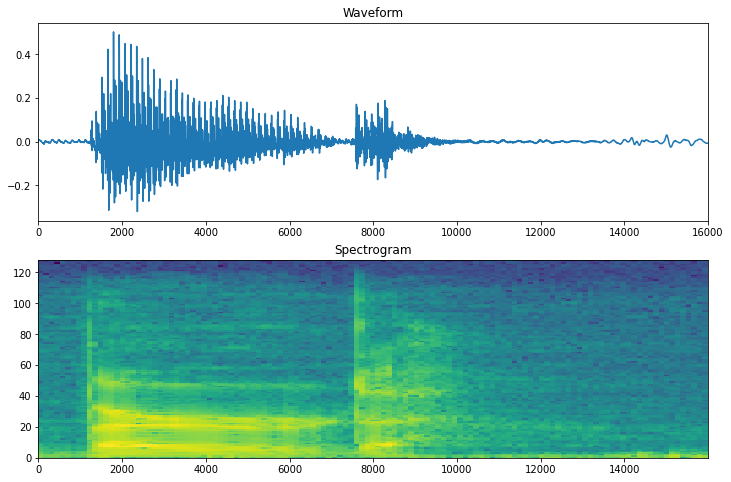

Audio playback


In [13]:

test_file = tf.io.read_file(train_files[0])
test_audio, _ = tf.audio.decode_wav(contents=test_file)
test_spectrogram = get_spectrogram(tf.squeeze(test_audio, axis=-1))

fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(test_audio.shape[0])
axes[0].plot(timescale, test_audio.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(test_spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

print('Audio playback')
display.display(display.Audio(tf.squeeze(test_audio, axis=-1), rate=16000))

Examine the spectrograms for different examples of the dataset:

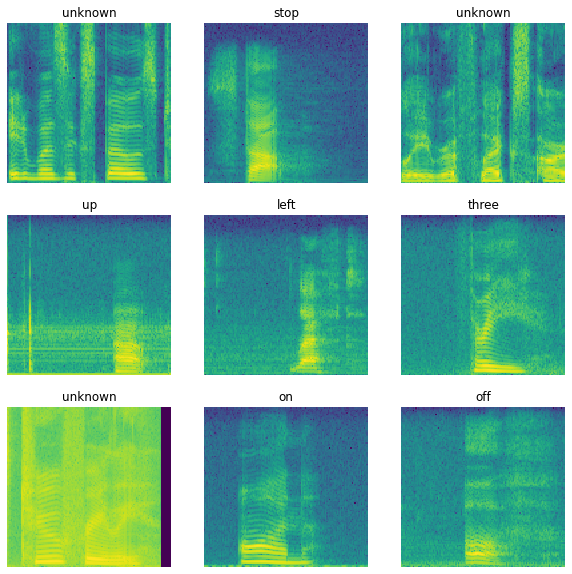

In [43]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

for i, (spectrogram, label_id) in enumerate(train_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(spectrogram.numpy(), ax)
  ax.set_title(commands[label_id.numpy()])
  ax.axis('off')
  
plt.show()

## Build and train the model

In [12]:
for spectrogram, _ in train_ds.take(1):
  input_shape = spectrogram.shape

print('Input shape:', input_shape)
num_labels = len(commands)

# Batch the training and validation sets for model training.
# Add Dataset.cache and Dataset.prefetch operations to reduce read latency while training the model:
batch_size = 64
train_ds = train_ds.padded_batch(batch_size).cache().prefetch(AUTOTUNE)
val_ds = val_ds.padded_batch(batch_size).cache().prefetch(AUTOTUNE)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_ds.map(map_func=lambda spec, label: spec))

Input shape: (124, 129)


In [14]:
def GRU_model(input_shape, norm_layer, rnn_layers=1):
  input = layers.Input(shape=input_shape)
  x = layers.Reshape((-1, input_shape[1], 1))(input)
  x = layers.Resizing(32,32)(x)
  x = norm_layer(x)
  x = layers.Conv2D(32, 3, activation='relu')(x)
  x = layers.Conv2D(64, 3, activation='relu')(x)
  x = layers.MaxPooling2D()(x)
  x = layers.Dropout(0.25)(x)
  print(x.shape)
  x = layers.Reshape((-1,x.shape[-2]*x.shape[-1]))(x)

  # RNN layers
  for i in range(1, rnn_layers + 1):
        recurrent = layers.GRU(
            units=128,
            activation="tanh",
            recurrent_activation="sigmoid",
            use_bias=True,
            return_sequences=True,
            reset_after=True,
            name=f"gru_{i}",
        )
        x = layers.Bidirectional(
            recurrent, name=f"bidirectional_{i}", merge_mode="concat"
        )(x)
        if i < rnn_layers:
            x = layers.Dropout(rate=0.5)(x)

  x = layers.Flatten()(x)
  x = layers.Dense(128, activation='relu')(x)
  x = layers.Dropout(0.5)(x)
  output = layers.Dense(num_labels)(x)
  model = tf.keras.Model(input, output)
  return model


def simple_model(input_shape, norm_layer):
  model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Reshape((-1, input_shape[1], 1)),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    #layers.BatchNormalization(),
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Reshape((-1, )),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
  ])
  return model



Configure the Keras model with the Adam optimizer and the cross-entropy loss:

In [15]:
model_name = os.path.join(gdrive_base, 'model/speech_command_GRU_base_%d.tf' % rnn_layers)

In [15]:
print(model_name)

model=GRU_model(input_shape, norm_layer, rnn_layers=rnn_layers)
model.summary()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

/content/gdrive/My Drive/Colab Notebooks/PicarSpeechCommands/model/speech_command_GRU_base_2.tf
(None, 14, 14, 64)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 124, 129)]        0         
                                                                 
 reshape (Reshape)           (None, 124, 129, 1)       0         
                                                                 
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizatio  (None, 32, 32, 129)      259       
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        37184     
                                                                 
 conv2d_1 (C

In [16]:
tf.config.run_functions_eagerly(True)

Train the model.

In [18]:
EPOCHS =10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[tf.keras.callbacks.EarlyStopping(verbose=1, patience=3),
               tf.keras.callbacks.ModelCheckpoint(filepath=model_name, verbose=1, save_best_only=True)],
)


Epoch 1/10
1006/1006 [==============================] - ETA: 0s - loss: 1.5030 - accuracy: 0.5725
Epoch 00001: val_loss improved from inf to 0.61041, saving model to /content/gdrive/My Drive/Colab Notebooks/PicarSpeechCommands/model/speech_command_GRU_base_2.tf


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Colab Notebooks/PicarSpeechCommands/model/speech_command_GRU_base_2.tf/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Colab Notebooks/PicarSpeechCommands/model/speech_command_GRU_base_2.tf/assets


1006/1006 [==============================] - 218s 216ms/step - loss: 1.5030 - accuracy: 0.5725 - val_loss: 0.6104 - val_accuracy: 0.8221
Epoch 2/10
1006/1006 [==============================] - ETA: 0s - loss: 0.7768 - accuracy: 0.7739
Epoch 00002: val_loss improved from 0.61041 to 0.53830, saving model to /content/gdrive/My Drive/Colab Notebooks/PicarSpeechCommands/model/speech_command_GRU_base_2.tf


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Colab Notebooks/PicarSpeechCommands/model/speech_command_GRU_base_2.tf/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Colab Notebooks/PicarSpeechCommands/model/speech_command_GRU_base_2.tf/assets


1006/1006 [==============================] - 165s 165ms/step - loss: 0.7768 - accuracy: 0.7739 - val_loss: 0.5383 - val_accuracy: 0.8504
Epoch 3/10
1006/1006 [==============================] - ETA: 0s - loss: 0.6346 - accuracy: 0.8181
Epoch 00003: val_loss improved from 0.53830 to 0.45529, saving model to /content/gdrive/My Drive/Colab Notebooks/PicarSpeechCommands/model/speech_command_GRU_base_2.tf


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Colab Notebooks/PicarSpeechCommands/model/speech_command_GRU_base_2.tf/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Colab Notebooks/PicarSpeechCommands/model/speech_command_GRU_base_2.tf/assets


1006/1006 [==============================] - 162s 161ms/step - loss: 0.6346 - accuracy: 0.8181 - val_loss: 0.4553 - val_accuracy: 0.8689
Epoch 4/10
1006/1006 [==============================] - ETA: 0s - loss: 0.5876 - accuracy: 0.8337
Epoch 00004: val_loss improved from 0.45529 to 0.42584, saving model to /content/gdrive/My Drive/Colab Notebooks/PicarSpeechCommands/model/speech_command_GRU_base_2.tf


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Colab Notebooks/PicarSpeechCommands/model/speech_command_GRU_base_2.tf/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Colab Notebooks/PicarSpeechCommands/model/speech_command_GRU_base_2.tf/assets


1006/1006 [==============================] - 162s 161ms/step - loss: 0.5876 - accuracy: 0.8337 - val_loss: 0.4258 - val_accuracy: 0.8756
Epoch 5/10
1006/1006 [==============================] - ETA: 0s - loss: 0.5327 - accuracy: 0.8498
Epoch 00005: val_loss did not improve from 0.42584
1006/1006 [==============================] - 98s 97ms/step - loss: 0.5327 - accuracy: 0.8498 - val_loss: 0.4473 - val_accuracy: 0.8772
Epoch 6/10
1006/1006 [==============================] - ETA: 0s - loss: 0.5154 - accuracy: 0.8558
Epoch 00006: val_loss did not improve from 0.42584
1006/1006 [==============================] - 97s 96ms/step - loss: 0.5154 - accuracy: 0.8558 - val_loss: 0.4523 - val_accuracy: 0.8826
Epoch 7/10
1006/1006 [==============================] - ETA: 0s - loss: 0.4897 - accuracy: 0.8611
Epoch 00007: val_loss improved from 0.42584 to 0.42251, saving model to /content/gdrive/My Drive/Colab Notebooks/PicarSpeechCommands/model/speech_command_GRU_base_2.tf


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Colab Notebooks/PicarSpeechCommands/model/speech_command_GRU_base_2.tf/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Colab Notebooks/PicarSpeechCommands/model/speech_command_GRU_base_2.tf/assets


1006/1006 [==============================] - 161s 160ms/step - loss: 0.4897 - accuracy: 0.8611 - val_loss: 0.4225 - val_accuracy: 0.8897
Epoch 8/10
1006/1006 [==============================] - ETA: 0s - loss: 0.4817 - accuracy: 0.8663
Epoch 00008: val_loss improved from 0.42251 to 0.42101, saving model to /content/gdrive/My Drive/Colab Notebooks/PicarSpeechCommands/model/speech_command_GRU_base_2.tf


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Colab Notebooks/PicarSpeechCommands/model/speech_command_GRU_base_2.tf/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Colab Notebooks/PicarSpeechCommands/model/speech_command_GRU_base_2.tf/assets


1006/1006 [==============================] - 160s 160ms/step - loss: 0.4817 - accuracy: 0.8663 - val_loss: 0.4210 - val_accuracy: 0.8899
Epoch 9/10
1006/1006 [==============================] - ETA: 0s - loss: 0.4816 - accuracy: 0.8656
Epoch 00009: val_loss did not improve from 0.42101
1006/1006 [==============================] - 97s 96ms/step - loss: 0.4816 - accuracy: 0.8656 - val_loss: 0.4433 - val_accuracy: 0.8910
Epoch 10/10
1006/1006 [==============================] - ETA: 0s - loss: 0.4790 - accuracy: 0.8651
Epoch 00010: val_loss improved from 0.42101 to 0.41885, saving model to /content/gdrive/My Drive/Colab Notebooks/PicarSpeechCommands/model/speech_command_GRU_base_2.tf


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Colab Notebooks/PicarSpeechCommands/model/speech_command_GRU_base_2.tf/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Colab Notebooks/PicarSpeechCommands/model/speech_command_GRU_base_2.tf/assets


1006/1006 [==============================] - 159s 159ms/step - loss: 0.4790 - accuracy: 0.8651 - val_loss: 0.4188 - val_accuracy: 0.8933
/content/gdrive/My Drive/Colab Notebooks/PicarSpeechCommands/model/speech_command_GRU_base_2.tf


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Colab Notebooks/PicarSpeechCommands/model/speech_command_GRU_base_2.tf_forlite/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Colab Notebooks/PicarSpeechCommands/model/speech_command_GRU_base_2.tf_forlite/assets


In [31]:
# convert to TFLite
def convert_to_tflite(model, model_name):
  print(model_name)
  run_model = tf.function(lambda x: model(x))
  # This is important, let's fix the input size.
  BATCH_SIZE = 1
  STEPS = 124
  INPUT_SIZE = 129
  concrete_func = run_model.get_concrete_function(
      tf.TensorSpec([BATCH_SIZE, STEPS, INPUT_SIZE], model.inputs[0].dtype))

  # Load weights from the best model during training
  model.load_weights(model_name)
  model.save(model_name + "_forlite", save_format=tf, signatures=concrete_func)

  converter = tf.lite.TFLiteConverter.from_saved_model(model_name + "_forlite")
  tflite_model = converter.convert()
  with open(model_name + '.tflite', 'wb') as f:
    f.write(tflite_model)

In [ ]:
convert_to_tflite(model, model_name)

Let's plot the training and validation loss curves to check how your model has improved during training:

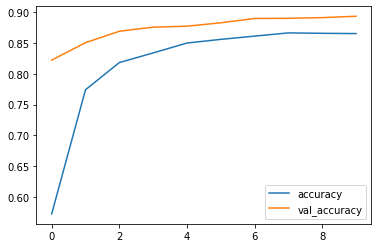

In [19]:
metrics = history.history
plt.plot(history.epoch, metrics['accuracy'], metrics['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

## Evaluate the tensorflow model performance

Run the model on the test set and check the model's performance:

In [20]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [17]:
loaded_model = load_model(model_name)

In [21]:
print(len(test_audio))
timestr = datetime.utcnow().strftime('%Y-%m-%d-%H-%M-%S.%f')[:-3]
print('Start time:', timestr)
y_pred = np.argmax(loaded_model.predict(test_audio), axis=1)
timestr = datetime.utcnow().strftime('%Y-%m-%d-%H-%M-%S.%f')[:-3]
print('End time:', timestr)
test_acc = sum(y_pred == test_labels) / len(test_labels)
print(f'Test set accuracy: {test_acc:.0%}')


8405
Start time: 2022-01-03-03-47-16.738


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


End time: 2022-01-03-03-47-26.404
Test set accuracy: 89%


### Display a confusion matrix

Use a <a href="https://developers.google.com/machine-learning/glossary#confusion-matrix" class="external">confusion matrix</a> to check how well the model did classifying each of the commands in the test set:


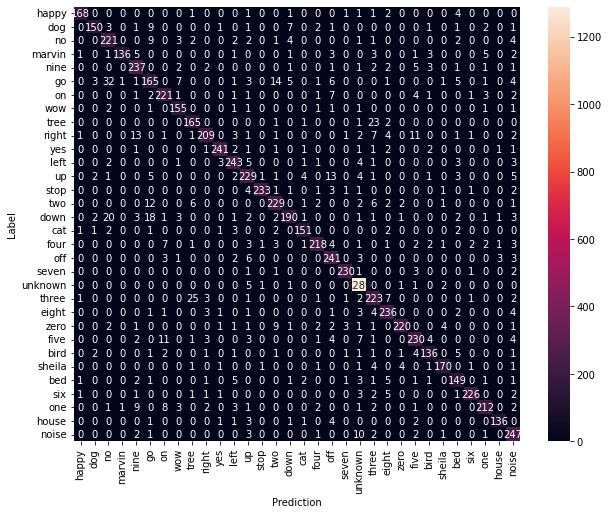

In [22]:
confusion_mtx = tf.math.confusion_matrix(test_labels, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=commands,
            yticklabels=commands,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## Eval TF Lite Model Performance

In [37]:
def tflite_get_preds(tflite_interpreter, spectrograms):
  input_details = tflite_interpreter.get_input_details()
  output_details = tflite_interpreter.get_output_details()
  preds = []
  scores = []

  # record start time
  print(datetime.utcnow().strftime('%Y-%m-%d-%H-%M-%S.%f')[:-3])
  for spectrogram in spectrograms:
    spectrogram = tf.reshape(spectrogram, (-1, spectrogram.shape[-2], spectrogram.shape[-1]))
    tflite_interpreter.set_tensor(input_details[0]["index"], np.array(spectrogram, dtype=np.float32))
    tflite_interpreter.invoke()
    output = tflite_interpreter.get_tensor(output_details[0]["index"])
    softmax = tf.nn.softmax(output[0])
    scores.append(tf.math.reduce_max(softmax))
    preds.append(tf.argmax(output, axis=1).numpy()[0])
  print(datetime.utcnow().strftime('%Y-%m-%d-%H-%M-%S.%f')[:-3])
  return (preds, scores)

In [42]:
def eval_tflite(model_name, test_input, test_output, commands):
  tflite_interpreter = tf.lite.Interpreter(model_name)
  tflite_interpreter.allocate_tensors()
  preds, scores = tflite_get_preds(tflite_interpreter, test_input)

  # Accuracy
  test_acc = sum(preds == test_output) / len(test_output)
  print(f'Test set accuracy: {test_acc:.0%}')

  # confusion matrix
  confusion_mtx = tf.math.confusion_matrix(test_output, preds)
  plt.figure(figsize=(10, 8))
  sns.heatmap(confusion_mtx,
              xticklabels=commands,
              yticklabels=commands,
              annot=True, fmt='g')
  plt.xlabel('Prediction')
  plt.ylabel('Label')
  plt.show()

In [25]:
print(model_name + '.tflite')

/content/gdrive/My Drive/Colab Notebooks/PicarSpeechCommands/model/speech_command_GRU_base_2.tf.tflite


2022-01-03-03-48-11.439
2022-01-03-03-49-45.795
Test set accuracy: 89%


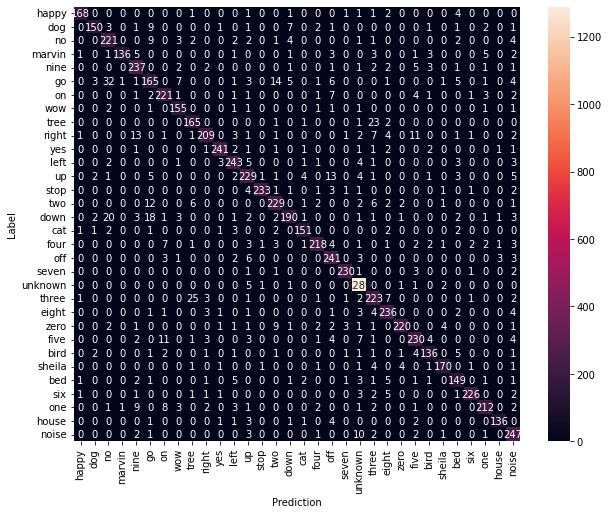

In [26]:
eval_tflite(model_name + '.tflite', test_audio, test_labels, commands)
  


# Refined model training
Now we will use the dataset for our customized commands list to finetune the base model.

## Load refine data set

In [18]:
REFINE_DATASET_PATH = 'data/refine_speech_commands'
refine_data_dir = pathlib.Path(REFINE_DATASET_PATH)

if not refine_data_dir.exists():
  shutil.copyfile(os.path.join(gdrive_base, "data/refine-data-set-%s.zip" % MODEL_VERSION), "data/refine-data-set.zip")
  with ZipFile('data/refine-data-set.zip', 'r') as zipf:
      zipf.extractall(REFINE_DATASET_PATH)

# Create training, validation and test set
filenames = tf.io.gfile.glob(str(refine_data_dir) + '/*/*.wav')
filenames = tf.random.shuffle(filenames)
print('Number of total files:', len(filenames))

refine_train_size = int(len(filenames) * 0.8)
refine_val_size = int(len(filenames) * 0.1)
refine_train_files = filenames[:refine_train_size]
refine_val_files = filenames[refine_train_size: refine_train_size + refine_val_size]
refine_test_files = filenames[-refine_val_size:]

print('Training set size', len(refine_train_files))
print('Validation set size', len(refine_val_files))
print('Test set size', len(refine_test_files))
print(refine_train_files[0:2])

refine_label_list = list(map(lambda x: x.split('/')[-1].split('.')[0], tf.io.gfile.glob(str(refine_data_dir) + '/*/*.wav')))
print(Counter(refine_label_list))

refine_commands = list(set(refine_label_list))
print('Total classes: %d' % len(refine_commands))
print(refine_commands)

Number of total files: 23048
Training set size 18438
Validation set size 2304
Test set size 2304
tf.Tensor(
[b'data/refine_speech_commands/training/unknown.fc94edb0_nohash_0.wav'
 b'data/refine_speech_commands/training/backward.cloud_en-US_en-US-Wavenet-H_8_1.wav'], shape=(2,), dtype=string)
Counter({'unknown': 3204, 'backward': 2598, 'forward': 2596, 'drive': 2595, 'noise': 2500, 'stop': 2400, 'go': 2390, 'right': 2388, 'left': 2377})
Total classes: 9
['left', 'forward', 'noise', 'go', 'backward', 'right', 'drive', 'stop', 'unknown']


In [22]:
def get_refine_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  label_id = tf.argmax(label == refine_commands)
  return spectrogram, label_id
def refine_preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(
      map_func=get_waveform_and_label,
      num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(
      map_func=get_refine_spectrogram_and_label_id,
      num_parallel_calls=AUTOTUNE)
  return output_ds

In [23]:
AUTOTUNE = tf.data.AUTOTUNE
refine_train_ds = refine_preprocess_dataset(refine_train_files)
refine_val_ds = refine_preprocess_dataset(refine_val_files)
refine_test_ds = refine_preprocess_dataset(refine_test_files)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


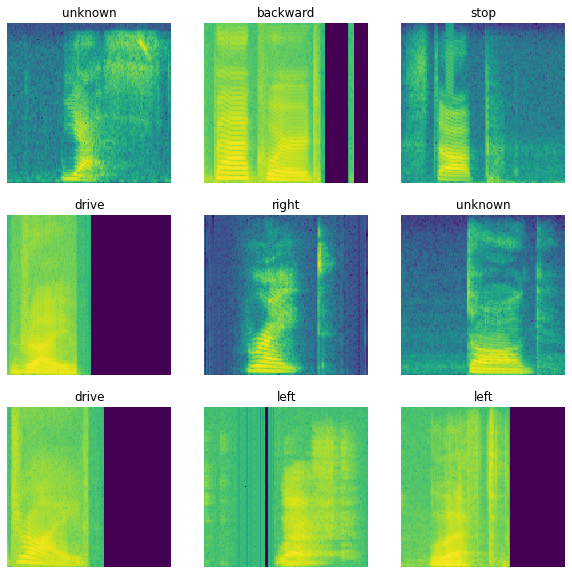

In [25]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

for i, (spectrogram, label_id) in enumerate(refine_train_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(spectrogram.numpy(), ax)
  ax.set_title(refine_commands[label_id.numpy()])
  ax.axis('off')
  
plt.show()

In [26]:
batch_size = 64
refine_train_ds = refine_train_ds.padded_batch(batch_size).cache().prefetch(AUTOTUNE)
refine_val_ds = refine_val_ds.padded_batch(batch_size).cache().prefetch(AUTOTUNE)

## Train the model

In [27]:
refine_model_name = os.path.join(gdrive_base, 'model/speech_command_GRU_refine_%s_%d.tf' % (MODEL_VERSION, rnn_layers))
print(refine_model_name)

/content/gdrive/My Drive/Colab Notebooks/PicarSpeechCommands/model/speech_command_GRU_refine_v2_2.tf


In [29]:
# load base model
refine_model = Sequential()
for layer in loaded_model.layers[:-1]: # go through until last layer
  refine_model.add(layer)
refine_model.add(layers.Dense(len(refine_commands), name='output'))

refine_model.summary()
refine_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 124, 129, 1)       0         
                                                                 
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizatio  (None, 32, 32, 129)      259       
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        37184     
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                    

In [33]:
EPOCHS =10
refine_history = refine_model.fit(
    refine_train_ds,
    validation_data=refine_val_ds,
    epochs=EPOCHS,
    callbacks=[tf.keras.callbacks.EarlyStopping(verbose=1, patience=5),
               tf.keras.callbacks.ModelCheckpoint(filepath=refine_model_name, verbose=1, save_best_only=True)],
)


Epoch 1/10
289/289 [==============================] - ETA: 0s - loss: 0.2943 - accuracy: 0.9073
Epoch 00001: val_loss improved from inf to 0.15746, saving model to /content/gdrive/My Drive/Colab Notebooks/PicarSpeechCommands/model/speech_command_GRU_refine_v2_2.tf


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Colab Notebooks/PicarSpeechCommands/model/speech_command_GRU_refine_v2_2.tf/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Colab Notebooks/PicarSpeechCommands/model/speech_command_GRU_refine_v2_2.tf/assets


289/289 [==============================] - 189s 656ms/step - loss: 0.2943 - accuracy: 0.9073 - val_loss: 0.1575 - val_accuracy: 0.9518
Epoch 2/10
289/289 [==============================] - ETA: 0s - loss: 0.2413 - accuracy: 0.9249
Epoch 00002: val_loss improved from 0.15746 to 0.15298, saving model to /content/gdrive/My Drive/Colab Notebooks/PicarSpeechCommands/model/speech_command_GRU_refine_v2_2.tf


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Colab Notebooks/PicarSpeechCommands/model/speech_command_GRU_refine_v2_2.tf/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Colab Notebooks/PicarSpeechCommands/model/speech_command_GRU_refine_v2_2.tf/assets


289/289 [==============================] - 121s 420ms/step - loss: 0.2413 - accuracy: 0.9249 - val_loss: 0.1530 - val_accuracy: 0.9605
Epoch 3/10
289/289 [==============================] - ETA: 0s - loss: 0.2273 - accuracy: 0.9291
Epoch 00003: val_loss improved from 0.15298 to 0.12929, saving model to /content/gdrive/My Drive/Colab Notebooks/PicarSpeechCommands/model/speech_command_GRU_refine_v2_2.tf


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Colab Notebooks/PicarSpeechCommands/model/speech_command_GRU_refine_v2_2.tf/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Colab Notebooks/PicarSpeechCommands/model/speech_command_GRU_refine_v2_2.tf/assets


289/289 [==============================] - 94s 326ms/step - loss: 0.2273 - accuracy: 0.9291 - val_loss: 0.1293 - val_accuracy: 0.9588
Epoch 4/10
289/289 [==============================] - ETA: 0s - loss: 0.2176 - accuracy: 0.9320
Epoch 00004: val_loss did not improve from 0.12929
289/289 [==============================] - 29s 99ms/step - loss: 0.2176 - accuracy: 0.9320 - val_loss: 0.1627 - val_accuracy: 0.9566
Epoch 5/10
289/289 [==============================] - ETA: 0s - loss: 0.2011 - accuracy: 0.9355
Epoch 00005: val_loss did not improve from 0.12929
289/289 [==============================] - 28s 98ms/step - loss: 0.2011 - accuracy: 0.9355 - val_loss: 0.1451 - val_accuracy: 0.9588
Epoch 6/10
289/289 [==============================] - ETA: 0s - loss: 0.1754 - accuracy: 0.9424
Epoch 00006: val_loss did not improve from 0.12929
289/289 [==============================] - 29s 99ms/step - loss: 0.1754 - accuracy: 0.9424 - val_loss: 0.1692 - val_accuracy: 0.9566
Epoch 7/10
289/289 [======

In [34]:
convert_to_tflite(refine_model, refine_model_name)

/content/gdrive/My Drive/Colab Notebooks/PicarSpeechCommands/model/speech_command_GRU_refine_v2_2.tf


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Colab Notebooks/PicarSpeechCommands/model/speech_command_GRU_refine_v2_2.tf_forlite/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Colab Notebooks/PicarSpeechCommands/model/speech_command_GRU_refine_v2_2.tf_forlite/assets


## Eval TFLite model

2022-01-03-04-45-21.120
2022-01-03-04-45-55.511
Test set accuracy: 96%


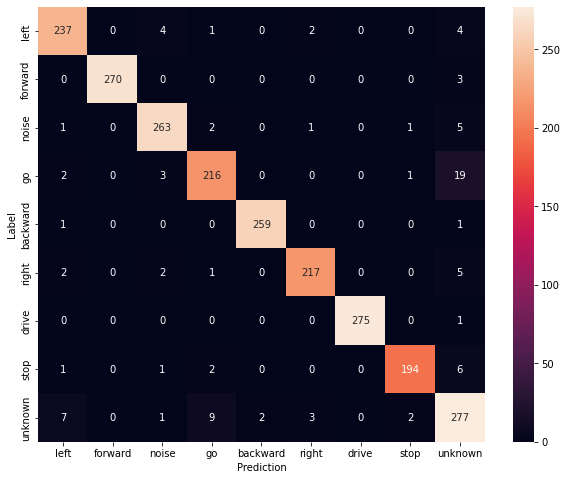

In [43]:
refine_test_audio = []
refine_test_labels = []

for audio, label in refine_test_ds:
  refine_test_audio.append(audio.numpy())
  refine_test_labels.append(label.numpy())

refine_test_audio = np.array(refine_test_audio)
refine_test_labels = np.array(refine_test_labels)
eval_tflite(refine_model_name + '.tflite', refine_test_audio, refine_test_labels, refine_commands)

## Apply model to a wav file

In [44]:
# get spectrograms for a wav file. Windows size is 1 second. Step is half second.
def get_spectrogram_for_file(file):
  spectrograms = []
  waves = []
  audio_binary = tf.io.read_file(file)
  audio, _ = tf.audio.decode_wav(contents=audio_binary)
  waveform = tf.squeeze(audio, axis=-1)
  print(waveform.shape) 
  frame_len = 16000  # window size is 1 second
  frame_step = 8000 # step is half second
  num_frames = len(waveform)//frame_step
  if waveform.shape[0] > num_frames * frame_step:
    num_frames += 1
  for i in range(num_frames):
    wave_one = waveform[i * frame_step: i * frame_step + frame_len]
    waves.append(wave_one)
    zero_padding = tf.zeros([16000] - tf.shape(wave_one), dtype=tf.float32)
    wave_one = tf.cast(wave_one, dtype=tf.float32)
    equal_length = tf.concat([wave_one, zero_padding], 0)
    # Convert the waveform to a spectrogram via a STFT.
    spectrogram = tf.signal.stft(
        equal_length, frame_length=255, frame_step=128)
    # Obtain the magnitude of the STFT.
    spectrogram = tf.abs(spectrogram)
    spectrograms.append(spectrogram)
  return(spectrograms, waves)

# Apply model to recorded wav file to check results
def tflite_model_for_file(wav_file):
  tflite_interpreter = tf.lite.Interpreter(model_path=refine_model_name + '.tflite')
  input_details = tflite_interpreter.get_input_details()
  output_details = tflite_interpreter.get_output_details()
  tflite_interpreter.allocate_tensors()
  
  spectrograms, waves = get_spectrogram_for_file(gdrive_base + "data/test_with_noise.wav")
  
  preds, scores = tflite_get_preds(tflite_interpreter, spectrograms)

  for i in range(len(spectrograms)):
    # Set a threshold to only output confident ones.
    if (scores[i] > 0.85):
      print('%s:%.2f' % (refine_commands[preds[i]], scores[i]))
      display.display(display.Audio(waves[i], rate=16000))

In [ ]:
tflite_model_for_file(gdrive_base + "data/test_with_noise.wav")

(160000,)
2022-01-02-20-38-07.183
unknown:1.00


backward:0.87


stop:0.86


unknown:0.95


left:1.00


left:0.90


right:1.00


unknown:1.00


stop:1.00


unknown:1.00


2022-01-02-20-38-08.151
[]
